# Cyber Security Threat Detection Using Machine Learning Frameworks

In [2]:
import os
os.chdir('C:\Ramya\IIT_Academics\Spring 2024\Machine Learning\Project')
filename = 'output_final.csv'

In [3]:
#Importing packages
import pandas as pd
import numpy as np
import seaborn as sns

from matplotlib import pyplot

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.model_selection import train_test_split, KFold, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.feature_selection import VarianceThreshold, SelectKBest, chi2, mutual_info_classif
from sklearn.ensemble import ExtraTreesClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC

from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras.layers import Lambda, Input, Dense
from keras.losses import binary_crossentropy

from pandas.plotting import scatter_matrix

from tensorflow.python.framework.ops import disable_eager_execution
# disable_eager_execution()  # Remove this line to enable eager execution

import warnings
warnings.filterwarnings('ignore')

from __future__ import print_function

In [4]:
# Create DataFrame
train = pd.read_csv(filename)
train_data = train.copy()
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Columns: 152 entries, 0 to 0.113
dtypes: float64(4), int64(148)
memory usage: 1.2 MB


# Data Preparation

In [5]:
array = train_data.values
X_train = array[:, 0:151]
y_train = array[:, 151]

In [6]:
# Split into a train and validation set
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=3)
print(X_train.shape)

(799, 151)


In [7]:
#Checking train and validation sets still splits across the target evenly
print(y_train.sum())
print(y_valid.sum())

9.0
2.0


### Normalise Data

In [8]:
norm_scaler = MinMaxScaler(feature_range=(0, 1), clip=True).fit(X_train)
n_X_train = norm_scaler.transform(X_train)
print(n_X_train.shape)

(799, 151)


In [9]:
n_X_valid = norm_scaler.transform(X_valid)
print(n_X_valid.shape)

(200, 151)


# Variational Autoencoder

In [11]:
#Variational Autoencoder is used to generate 20 additional features to add to the data set
class Sampling(keras.layers.Layer):
    def call(self, input_data):
        mean, log_var = input_data
        return keras.backend.random_normal(tf.shape(log_var)) * keras.backend.exp(log_var / 2) + mean

input_size = 151
code_size = 20

input_data = Input(shape=(input_size,))
hidden_1 = Dense(75, activation='relu')(input_data)
hidden_2 = Dense(35, activation='relu')(hidden_1)

code_mean = Dense(code_size)(hidden_2)
code_log_var = Dense(code_size)(hidden_2)
code = Sampling()([code_mean, code_log_var])

var_encoder = Model(input_data, outputs=code)

decoder_inputs = Input(shape=[code_size])
hidden_3 = Dense(35, activation='relu')(decoder_inputs)
hidden_4 = Dense(75, activation='relu')(hidden_3)
output_data = Dense(input_size, activation='sigmoid')(hidden_4)

var_decoder = Model(inputs=decoder_inputs, outputs=output_data)

code_input = Input(shape=(code_size,))
reconst = var_decoder(code_input)
var_ae = Model(inputs=code_input, outputs=reconst)

In [12]:
# Custom loss function for Variational Autoencoder
def losses_func(input_data, reconst):
    code_mean = var_encoder(input_data)
    code_log_var = var_encoder(input_data)
    latent_loss = -0.5 * tf.reduce_sum(1 + code_log_var - tf.exp(code_log_var) - tf.square(code_mean), axis=-1)
    reconstruction_loss = tf.keras.losses.binary_crossentropy(input_data, reconst)
    return (tf.reduce_mean(latent_loss) / 151.) + reconstruction_loss

var_ae.compile(optimizer='adam', loss=losses_func)

# Enabling eager execution
tf.config.run_functions_eagerly(True)

# Encode input data using the encoder model
encoded_train_data = var_encoder.predict(n_X_train)
encoded_valid_data = var_encoder.predict(n_X_valid)

# Train the Variational Autoencoder with the encoded features
history = var_ae.fit(x=encoded_train_data, y=n_X_train, epochs=10, validation_data=(encoded_valid_data, n_X_valid))

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.7638 - val_loss: 0.5863
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.5048 - val_loss: 0.3162
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.2859 - val_loss: 0.2491
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.2470 - val_loss: 0.2377
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.2379 - val_loss: 0.2359
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.2376 - val_loss: 0.2383
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.2320 - val_loss: 0.2338
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.2338 - val_loss: 0.2324
Epoch 9/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.2328 - val_loss: 0.2322
Epoch 10/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.2343 - val_loss: 0.2331


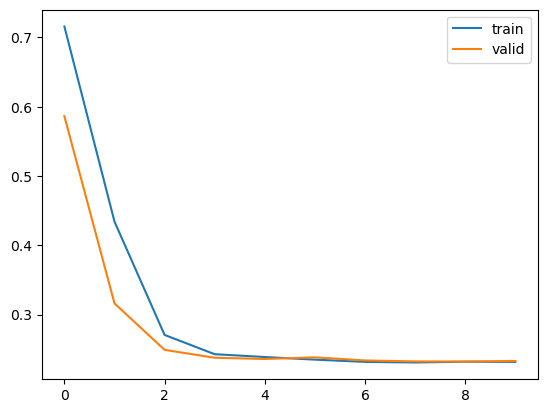

In [13]:
pyplot.plot(history.history['loss'],label = 'train')
pyplot.plot(history.history['val_loss'], label = 'valid')
pyplot.legend()
pyplot.show()  

In [14]:
#The trained variational encoder contains the reduced features from the code layer
encoded = var_encoder
gen_feat = encoded.predict(n_X_train)
print(gen_feat.shape)

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
(799, 20)


In [15]:
#Statistics of the generated output features
gen_featdf = pd.DataFrame(gen_feat)
gen_featdf.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
count,799.000000,799.000000,799.000000,799.000000,799.000000,799.000000,799.000000,799.000000,799.000000,799.000000,799.000000,799.000000,799.000000,799.000000,799.000000,799.000000,799.000000,799.000000,799.000000,799.000000
mean,0.012579,0.248887,-0.151061,0.231326,-0.050255,-0.162416,-0.164377,-0.112620,-0.175843,0.105194,-0.302976,0.074969,-0.250736,-0.141972,0.076874,-0.046024,-0.252972,-0.112703,-0.139818,-0.129682
std,1.076697,0.977273,1.144164,0.912999,0.985630,0.955183,1.166511,1.003431,0.984224,0.892922,1.076948,0.980414,0.933338,1.132627,0.969560,1.024625,1.082380,1.059683,1.011476,1.017622
min,-3.205641,-2.645231,-3.707814,-2.776168,-3.347886,-3.622074,-3.206503,-4.032089,-3.227153,-2.526697,-3.421523,-2.778472,-3.547342,-3.910678,-3.030385,-3.802275,-4.218303,-2.978616,-3.699072,-2.974259
25%,-0.693434,-0.378949,-0.878480,-0.364769,-0.704547,-0.817090,-0.956001,-0.772483,-0.838138,-0.462319,-1.030788,-0.602155,-0.863337,-0.883323,-0.565127,-0.757496,-0.945808,-0.828233,-0.789063,-0.801219
50%,0.019164,0.266654,-0.181249,0.248142,0.015995,-0.200307,-0.121626,-0.077643,-0.174518,0.097041,-0.282320,0.119732,-0.271355,-0.146546,0.099368,-0.032863,-0.290560,-0.138645,-0.168997,-0.174774
75%,0.637879,0.889910,0.598679,0.850577,0.624198,0.481988,0.631119,0.565276,0.440888,0.651697,0.436539,0.705410,0.351088,0.587525,0.729086,0.700601,0.504667,0.554157,0.505073,0.527966
max,3.456403,3.290045,4.267019,2.852998,3.217038,4.047306,3.567671,2.751348,2.790703,3.367896,2.942042,4.131845,2.906036,2.953230,4.121284,3.217547,3.881460,2.918053,2.449868,3.504914


The Variational Encoder code layer, the generated features have a mean of 0 and a standard deviation of 1

In [16]:
#Normalising the generated features and creating a dataframe with new column labels
norm_scaler20 = MinMaxScaler(feature_range = (0,1), clip = True).fit(gen_feat)
n_gen_feat = norm_scaler20.transform(gen_feat)
n_gen_feat = pd.DataFrame(n_gen_feat)
new_col_headers = map(str,[160,161,162,163,164,165,166,167,168,169, 170,171,172,173,174,175,176,177,178,179])
n_gen_feat.columns= new_col_headers

In [17]:
#Adding generated features dataframe to original features dataframe
num_data = open('column_names.csv') #Column names
num_lst = []
for label in num_data:
    label = label.rstrip()
    num_lst.append(label)

n_orig_feat = pd.DataFrame(n_X_train, columns = num_lst)
n_all_feat = pd.concat([n_orig_feat,n_gen_feat],axis = 1)
print(n_all_feat.shape)

(799, 171)
